<a href="https://colab.research.google.com/github/Yohk2291/MachineLearning/blob/master/RNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kerasを使ったRNNの実装

映画レビューのデータセット(imdb)でRNNの各手法を実装

In [1]:
from keras.models import Sequential
from keras.datasets import imdb
from keras.layers import Dense, Activation, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import np_utils, to_categorical
from keras.preprocessing import sequence
import numpy as np

from matplotlib import pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
max_features = 10000 # 取得する単語数（頻出順に1万語）
maxlen = 500 # 1レビューの長さ（これを超える文章は削られ、足りない文章は?で埋められる）

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
# ターゲットをfloat32に変換（このままだとint64なので）
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [13]:
# インデックスと単語を対応させる辞書の作成
word_index = imdb.get_word_index() #wordがkey、valueがindex
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 最初の10レビューを眺めてみる（500単語に満たないレビューは?で埋められている点も注目）
for k in range(10):
  decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[k]])
  if y_train[k] == 1:
    print('positive')
  else:
    print('negative')
  print(decoded_review)

positive
? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought

## LSTM

In [14]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer='glorot_uniform', input_length=maxlen))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epoch = 5

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm = model.fit(X_train, y_train, batch_size=256, epochs=num_epoch, validation_split=0.2)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 75s 4ms/step - loss: 0.5841 - acc: 0.7042 - val_loss: 0.4297 - val_acc: 0.8078
Epoch 2/5
20000/20000 [==============================] - 69s 3ms/step - loss: 0.3591 - acc: 0.8538 - val_loss: 0.3616 - val_acc: 0.8430
Epoch 3/5
20000/20000 [==============================] - 69s 3ms/step - loss: 0.2503 - acc: 0.9057 - val_loss: 0.3369 - val_acc: 0.8590
Epoch 4/5
20000/20000 [==============================] - 73s 4ms/step - loss: 0.1884 - acc: 0.9356 - val_loss: 0.3417 - val_acc: 0.8618
Epoch 5/5
20000/20000 [==============================] - 73s 4ms/step - loss: 0.1440 - acc: 0.9545 - val_loss: 0.3513 - val_acc: 0.8706


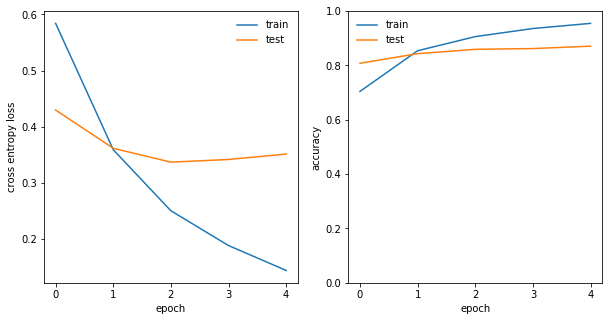

Maximum val_acc: 0.87060


In [16]:
# 学習曲線の描画
fig = plt.figure(figsize=(10,5))

# loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), lstm.history['loss'], label='train')
plt.plot(range(num_epoch), lstm.history['val_loss'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

# accuracy
plt.subplot(1, 2, 2)
plt.ylim(0., 1.)
plt.plot(range(num_epoch), lstm.history['acc'], label='train')
plt.plot(range(num_epoch), lstm.history['val_acc'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

print('Maximum val_acc: {:.5f}'.format(np.max(lstm.history['val_acc'])))

## Bidirectional LSTM

In [17]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer='glorot_uniform', input_length=maxlen))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,034,113
Trainable params: 1,034,113
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epoch = 5

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

bilstm = model.fit(X_train, y_train, batch_size=256, epochs=num_epoch, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 152s 8ms/step - loss: 0.5411 - acc: 0.7285 - val_loss: 0.3879 - val_acc: 0.8352
Epoch 2/5
20000/20000 [==============================] - 150s 7ms/step - loss: 0.3038 - acc: 0.8802 - val_loss: 0.3293 - val_acc: 0.8686
Epoch 3/5
20000/20000 [==============================] - 148s 7ms/step - loss: 0.2200 - acc: 0.9190 - val_loss: 0.3242 - val_acc: 0.8772
Epoch 4/5
20000/20000 [==============================] - 149s 7ms/step - loss: 0.1591 - acc: 0.9466 - val_loss: 0.3393 - val_acc: 0.8726
Epoch 5/5
20000/20000 [==============================] - 148s 7ms/step - loss: 0.1191 - acc: 0.9627 - val_loss: 0.3797 - val_acc: 0.8760


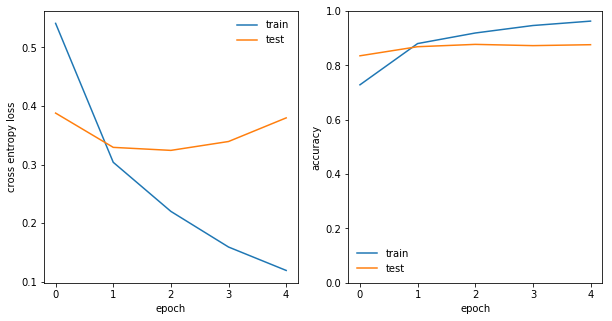

Maximum val_acc: 0.87720


In [19]:
# 学習曲線の描画
fig = plt.figure(figsize=(10,5))

# loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), bilstm.history['loss'], label='train')
plt.plot(range(num_epoch), bilstm.history['val_loss'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

# accuracy
plt.subplot(1, 2, 2)
plt.ylim(0., 1.)
plt.plot(range(num_epoch), bilstm.history['acc'], label='train')
plt.plot(range(num_epoch), bilstm.history['val_acc'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

print('Maximum val_acc: {:.5f}'.format(np.max(bilstm.history['val_acc'])))

## GRU

In [20]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer='glorot_uniform', input_length=maxlen))
model.add(GRU(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,012,801
Trainable params: 1,012,801
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epoch = 5

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

gru = model.fit(X_train, y_train, batch_size=256, epochs=num_epoch, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 61s 3ms/step - loss: 0.5892 - acc: 0.6799 - val_loss: 0.3990 - val_acc: 0.8256
Epoch 2/5
20000/20000 [==============================] - 58s 3ms/step - loss: 0.3069 - acc: 0.8722 - val_loss: 0.3925 - val_acc: 0.8252
Epoch 3/5
20000/20000 [==============================] - 58s 3ms/step - loss: 0.2378 - acc: 0.9083 - val_loss: 0.3752 - val_acc: 0.8390
Epoch 4/5
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1970 - acc: 0.9277 - val_loss: 0.3657 - val_acc: 0.8562
Epoch 5/5
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1544 - acc: 0.9456 - val_loss: 0.3897 - val_acc: 0.8462


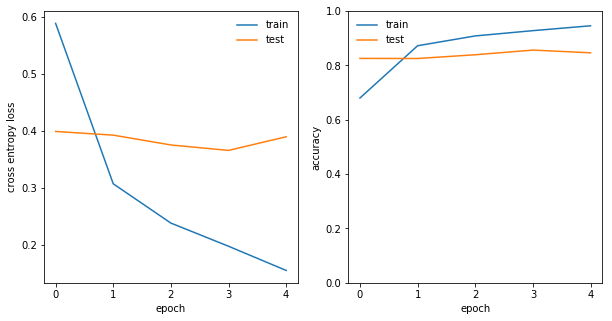

Maximum val_acc: 0.85620


In [22]:
# 学習曲線の描画
fig = plt.figure(figsize=(10,5))

# loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), gru.history['loss'], label='train')
plt.plot(range(num_epoch), gru.history['val_loss'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

# accuracy
plt.subplot(1, 2, 2)
plt.ylim(0., 1.)
plt.plot(range(num_epoch), gru.history['acc'], label='train')
plt.plot(range(num_epoch), gru.history['val_acc'], label='test')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

print('Maximum val_acc: {:.5f}'.format(np.max(gru.history['val_acc'])))